<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

/Users/mdashikadnan/Documents/adnanedu/python/ztm/pytorch/pytorch-deep-learning/pytorch_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup device agnostic code
# Setup device agnostic code
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

device = set_device()
print(f"Using device: {device}")

Using device: mps


### Get data 

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x16742f0e0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/Users/mdashikadnan/Documents/adnanedu/python/ztm/pytorch/pytorch-deep-learning/pytorch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mdashikadnan/Documents/adnanedu/python/ztm/pytorch/pytorch-deep-learning/pytorch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
# torch.cuda.manual_seed(42)
torch.mps.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
# torch.cuda.manual_seed(42)
torch.mps.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:04<04:19, 64.94s/it]

Epoch: 1 | train_loss: 1.0834 | train_acc: 0.3906 | test_loss: 0.9157 | test_acc: 0.5085


 40%|████      | 2/5 [02:07<03:10, 63.44s/it]

Epoch: 2 | train_loss: 0.8704 | train_acc: 0.7695 | test_loss: 0.7983 | test_acc: 0.7434


 60%|██████    | 3/5 [03:11<02:07, 63.86s/it]

Epoch: 3 | train_loss: 0.7895 | train_acc: 0.7891 | test_loss: 0.7357 | test_acc: 0.7528


 80%|████████  | 4/5 [04:15<01:03, 63.90s/it]

Epoch: 4 | train_loss: 0.7256 | train_acc: 0.7500 | test_loss: 0.6558 | test_acc: 0.8968


100%|██████████| 5/5 [05:19<00:00, 63.97s/it]

Epoch: 5 | train_loss: 0.6420 | train_acc: 0.7852 | test_loss: 0.6277 | test_acc: 0.8968
[INFO] Total training time: 319.853 seconds


### Make predictions on the entire test dataset with the model

In [36]:
from tqdm.auto import tqdm

test_preds = []
model_0.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)

        # Pass the data through the model
        test_logits = model_0(X)

        # Convert the pred logits to pred probs
        pred_probs = torch.softmax(test_logits, dim=1)

        # Convert the pred probs to pred labels
        pred_labels = torch.argmax(pred_probs, dim=1)

        # Add the pred labels to the list
        test_preds.append(pred_labels)


# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(test_preds).cpu()
y_pred_tensor

Making predictions...: 100%|██████████| 3/3 [00:22<00:00,  7.36s/it]


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [37]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [38]:
len(y_pred_tensor), len(test_truth)

(75, 75)

In [39]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [40]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


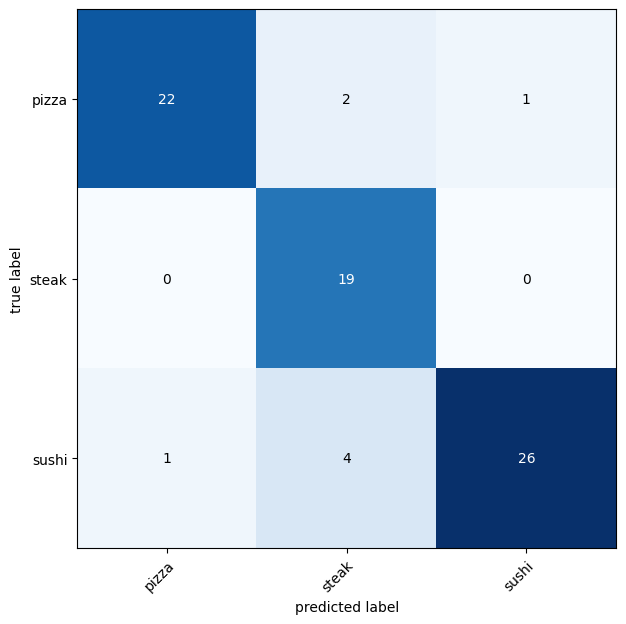

In [43]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [68]:
# Get all test data paths
from pathlib import Path
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]


def pred_and_store(test_paths, model, transform, class_names, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        pred_dict = {}

        pred_dict["image_path"] = path

        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(dim=0) # Transform the image then added batch dimension
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image.to(device))
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]
            
            pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
            pred_dict["pred_class"] = pred_class

            pred_dict["correct"] = class_name == pred_class

            test_pred_list.append(pred_dict)
    return test_pred_list
            


test_pred_dicts = pred_and_store(test_paths=test_data_paths,
               model=model_0,
               transform=simple_transform,
               class_names=class_names,
               device=device)
test_pred_dicts[:5]

100%|██████████| 75/75 [00:02<00:00, 28.68it/s]


[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9062049984931946,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7961286902427673,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.848923921585083,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7744466066360474,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.44498369097709656,
  'pred_class': 'steak',
  'correct': True}]

In [69]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd

test_pred_df = pd.DataFrame(test_pred_dicts)

# Sort the DataFrame by correct and then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
37,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.552076,steak,False
33,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.477742,steak,False
72,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.435276,steak,False
48,data/pizza_steak_sushi/test/sushi/2394442.jpg,sushi,0.426399,pizza,False
44,data/pizza_steak_sushi/test/sushi/2276986.jpg,sushi,0.426231,steak,False


/var/folders/g5/58p5c8f568398j2qrhdc7smw0000gn/T/ipykernel_4571/410343107.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
/var/folders/g5/58p5c8f568398j2qrhdc7smw0000gn/T/ipykernel_4571/410343107.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
/var/folders/g5/58p5c8f568398j2qrhdc7smw0000gn/T/ipykernel_4571/410343107.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]

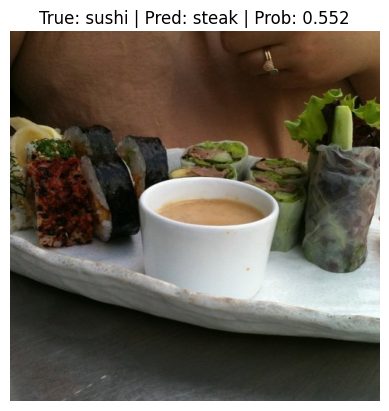

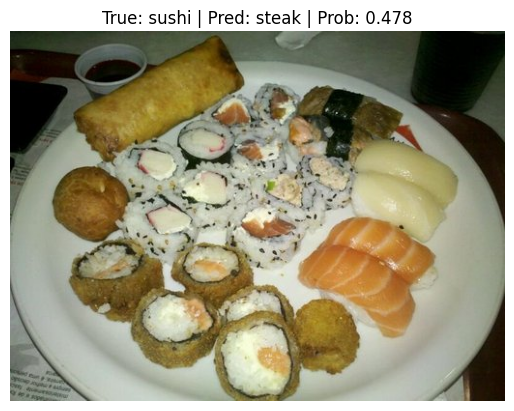

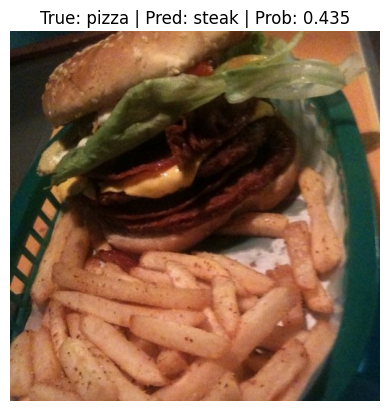

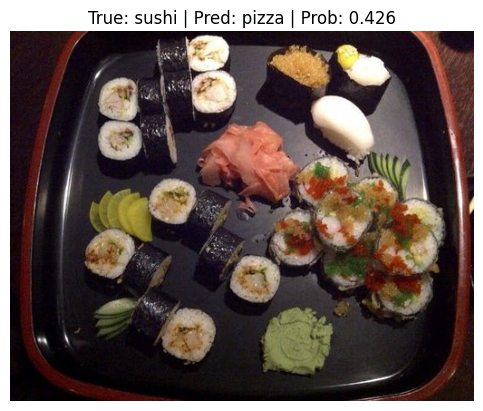

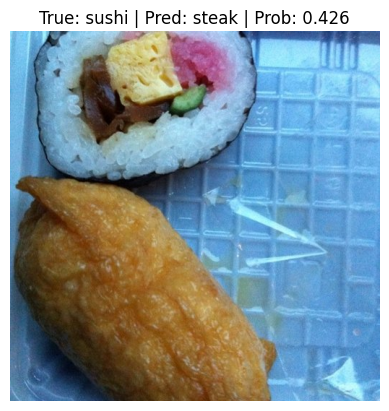

In [70]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [76]:
%pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=0d910cd0d55ccba876d8640be418eb8f489c417be1cbc6f76b9b5181c7a9d841
  Stored in directory: /Users/mdashikadnan/Library/Caches/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [111]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)
  
  # plot image and pred
  plt.figure() 
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False)

--2024-11-09 02:21:58--  https://images.unsplash.com/photo-1501735972267-d5c1bc03655c
Resolving images.unsplash.com (images.unsplash.com)... 151.101.82.208
Connecting to images.unsplash.com (images.unsplash.com)|151.101.82.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2611300 (2.5M) [image/jpeg]
Saving to: 'photo-1501735972267-d5c1bc03655c'

photo-1501735972267 100%[===================>]   2.49M  6.43MB/s    in 0.4s    

2024-11-09 02:21:58 (6.43 MB/s) - 'photo-1501735972267-d5c1bc03655c' saved [2611300/2611300]



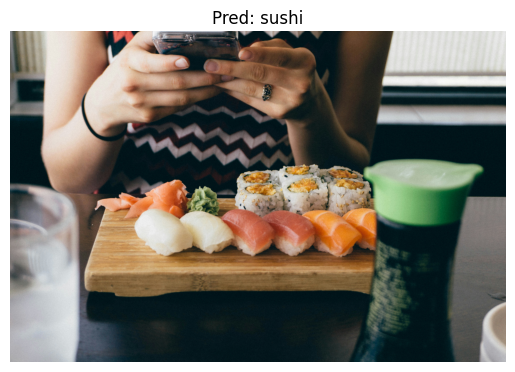

In [114]:
!wget https://images.unsplash.com/photo-1501735972267-d5c1bc03655c

!cp photo-1501735972267-d5c1bc03655c sushi.jpg

!rm photo-1501735972267-d5c1bc03655c

pred_and_plot("sushi.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2024-11-09 02:20:24--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 151.101.82.208
Connecting to images.unsplash.com (images.unsplash.com)|151.101.82.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617320 (3.4M) [image/jpeg]
Saving to: 'photo-1546964124-0cce460f38ef'

photo-1546964124-0c 100%[===================>]   3.45M  6.44MB/s    in 0.5s    

2024-11-09 02:20:24 (6.44 MB/s) - 'photo-1546964124-0cce460f38ef' saved [3617320/3617320]



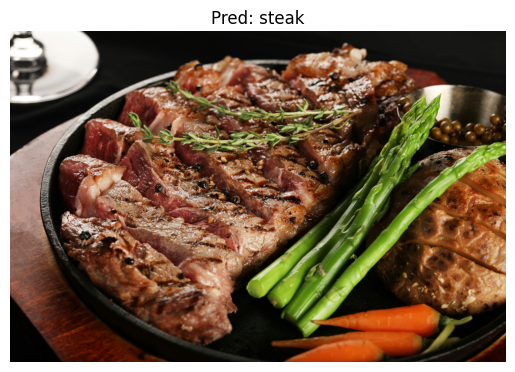

In [113]:
# Try again on a photo of steak from unsplash.com 
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg
!rm photo-1546964124-0cce460f38ef

pred_and_plot("steak.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2024-11-09 02:23:22--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.82.208
Connecting to images.unsplash.com (images.unsplash.com)|151.101.82.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3208960 (3.1M) [image/jpeg]
Saving to: 'photo-1588315029754-2dd089d39a1a'

photo-1588315029754 100%[===================>]   3.06M  6.51MB/s    in 0.5s    

2024-11-09 02:23:23 (6.51 MB/s) - 'photo-1588315029754-2dd089d39a1a' saved [3208960/3208960]



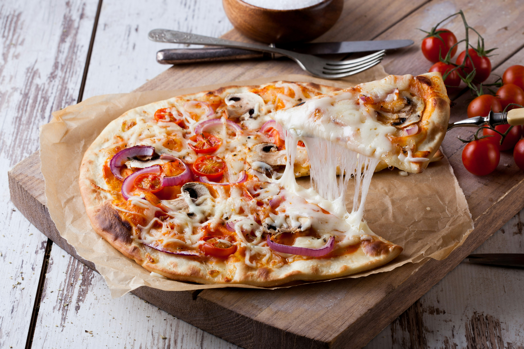

In [115]:
# TODO: Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

!rm photo-1588315029754-2dd089d39a1a

from PIL import Image

with Image.open("pizza.jpg") as img:
    # Reduce the image size and width by 10
    (width, height) = (img.width // 10, img.height //10)
    img_resized = img.resize((width, height))

img_resized

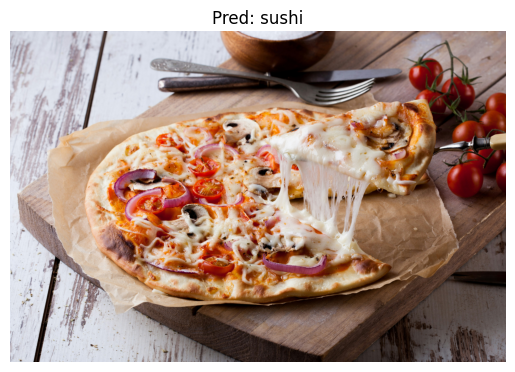

In [109]:
pred_and_plot(image_path="pizza.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2024-11-09 02:24:40--  https://plus.unsplash.com/premium_photo-1673439304183-8840bd0dc1bf
Resolving plus.unsplash.com (plus.unsplash.com)... 151.101.82.208
Connecting to plus.unsplash.com (plus.unsplash.com)|151.101.82.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7306895 (7.0M) [image/jpeg]
Saving to: 'premium_photo-1673439304183-8840bd0dc1bf'

premium_photo-16734 100%[===================>]   6.97M  6.47MB/s    in 1.1s    

2024-11-09 02:24:41 (6.47 MB/s) - 'premium_photo-1673439304183-8840bd0dc1bf' saved [7306895/7306895]



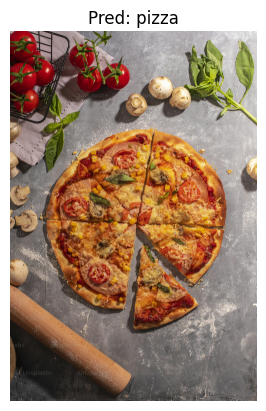

In [116]:
!wget https://plus.unsplash.com/premium_photo-1673439304183-8840bd0dc1bf

!cp premium_photo-1673439304183-8840bd0dc1bf pizza_2.jpg

!rm premium_photo-1673439304183-8840bd0dc1bf

pred_and_plot("pizza_2.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [ ]:
# TODO: Recreate a new model 


In [ ]:
# TODO: Train the model for 10 epochs

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5ede28e390>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [ ]:
# TODO

### Train a model with 20% of the data

In [ ]:
# TODO

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
# TODO 